Epoch 1/30
391/391 [==============================] - 11s 25ms/step - loss: 9.3934 - accuracy: 0.1304 - recall: 0.1139 - precision: 0.1536 - f1: 0.1307 - val_loss: 6.6372 - val_accuracy: 0.2007 - val_recall: 0.1745 - val_precision: 0.2391 - val_f1: 0.2016
Epoch 2/30
391/391 [==============================] - 10s 26ms/step - loss: 5.5798 - accuracy: 0.2369 - recall: 0.2055 - precision: 0.2922 - f1: 0.2411 - val_loss: 5.4341 - val_accuracy: 0.2396 - val_recall: 0.2073 - val_precision: 0.2976 - val_f1: 0.2442
Epoch 3/30
391/391 [==============================] - 10s 26ms/step - loss: 4.5478 - accuracy: 0.2827 - recall: 0.2401 - precision: 0.3635 - f1: 0.2889 - val_loss: 4.8738 - val_accuracy: 0.2622 - val_recall: 0.2226 - val_precision: 0.3318 - val_f1: 0.2662
Epoch 4/30
391/391 [==============================] - 9s 23ms/step - loss: 3.9531 - accuracy: 0.3127 - recall: 0.2606 - precision: 0.4158 - f1: 0.3200 - val_loss: 4.5318 - val_accuracy: 0.2766 - val_recall: 0.2316 - val_precision: 0

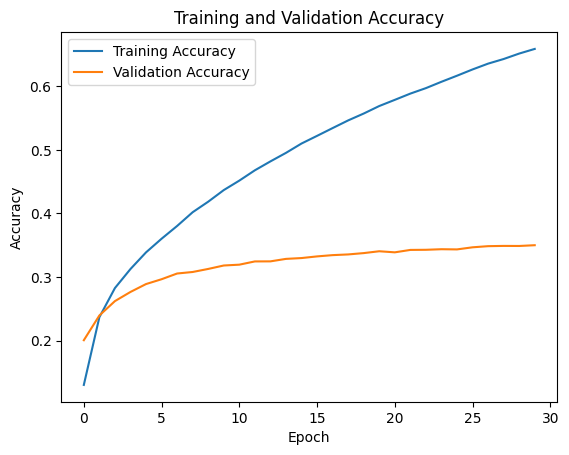

In [14]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar100
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.utils import to_categorical
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras import backend as K


# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon()))

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode= "fine")

# Preprocess the data
x_train = preprocess_input(x_train.astype("float32"))
x_test = preprocess_input(x_test.astype("float32"))
y_train = to_categorical(y_train, num_classes= 100)
y_test = to_categorical(y_test, num_classes= 100)

# Parameters
epochs = 30
batch_size = 128
learning_rate = 0.001
momentum = 0.9

# Load pre-trained VGG19 model
base_model = VGG19(weights= "imagenet", include_top= False, input_shape= (32, 32, 3))

# Add custom layers on top of pre-trained model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation= "relu")(x)
predictions = Dense(100, activation= "softmax")(x)


# Combine base model and custom layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with custom metrics
model.compile(optimizer= SGD(learning_rate= learning_rate, momentum= momentum),
              loss= "categorical_crossentropy",
              metrics= ["accuracy", recall, precision, f1])

# Train the model
history = model.fit(x_train, y_train, batch_size= batch_size, epochs= epochs, validation_data= (x_test, y_test))

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label= "Training Accuracy")
plt.plot(history.history["val_accuracy"], label= "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# **Epochs: 30     Learning Rate: 0.001    Momentum: 0.003    Batch size: 128**